## Домашнее задание #4: Линейная регрессия

### Дедлайн: 10 июня 2022 года, 23:59

Для проверки гипотез используйте ваш любимый уровень значимости! 

---

В этом задании нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

### Часть 1: Предобработка данных (2 балла)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

**Задание 1.** Загрузите данные из файла `weatherHistory.csv`. Выведите первые 5 строк таблицы.

In [2]:

df = pd.read_csv('weatherHistory.csv')
# df_weather = pd.DataFrame(df)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


**Задание 2.** Изучите статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index"). Удалите какую-то переменную из набора данных и поясните, почему вы её удалили (помните о том, какая переменная будет целевой). Также удалите переменные:
- `Formatted Date` (потому что договорились, что не обращаем внимания на даты).
- `Daily Summary` (будем использовать просто `Summary`). 

In [3]:
# 2-е действие
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


IQR (3Q - 1Q)\
верхняя граница нормы: 3Q + 1.5 * IQR\
нижняя граница нормы: 1Q + 1.5 * IQR

это boxplot

In [4]:
# описательные статистики
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [5]:
# считать пропуски
df.isna().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [6]:
df.duplicated().sum()

24

In [7]:
# показать дублирующие строки и отсортировать
df[df.duplicated()].sort_values(by='Visibility (km)').head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
36074,2010-08-02 02:00:00.000 +0200,Clear,rain,18.072222,18.072222,0.98,11.2700,290.0,6.8425,0.0,1013.23,Partly cloudy starting in the afternoon contin...
36082,2010-08-02 10:00:00.000 +0200,Clear,rain,27.688889,28.077778,0.50,0.2254,338.0,9.9820,0.0,1016.68,Partly cloudy starting in the afternoon contin...
36093,2010-08-02 21:00:00.000 +0200,Clear,rain,22.172222,22.172222,0.87,1.6100,0.0,9.9820,0.0,1013.49,Partly cloudy starting in the afternoon contin...
36090,2010-08-02 18:00:00.000 +0200,Partly Cloudy,rain,29.950000,30.416667,0.46,3.0751,303.0,9.9820,0.0,1013.59,Partly cloudy starting in the afternoon contin...
36077,2010-08-02 05:00:00.000 +0200,Clear,rain,15.955556,15.955556,0.99,3.8801,276.0,9.9820,0.0,1016.69,Partly cloudy starting in the afternoon contin...


In [8]:
# удалить дубли и перезаписать
df.drop_duplicates(inplace=True)

Мультиколлинеарность — требуется убрать созависимые признаки.

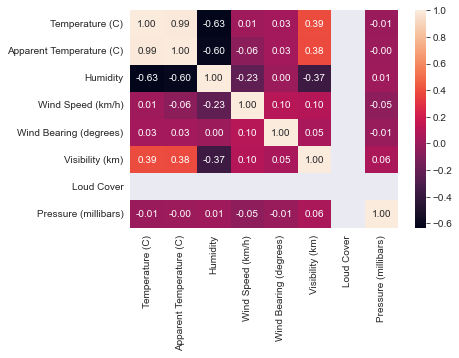

In [9]:
sns.heatmap(df.corr(), annot=True, fmt='.2f');

In [10]:
#удалить Loud Cover из-за пропущенных значений
df = df.drop(columns=['Formatted Date', 'Loud Cover', 'Daily Summary'], axis=1)

df

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51
...,...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36
96449,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16
96450,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66
96451,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,1015.95


**Задание 3.** Есть ли в наборе данных пропущенные значения? Если да, удалите их.

In [11]:
df.shape

(96429, 9)

In [12]:
nans = df.isna().sum().sum()

In [13]:
# вывести долю пропусков
print('{:.1%}'.format(nans / df.shape[0]))

0.5%


In [14]:
df.dropna(inplace=True)

**Задание 4.** В данных есть одна числовая переменная, которая не несёт информации для предсказания целевой переменной. Найдите эту переменную, поясните ваш выбор и удалите её. 

In [15]:
#df_weather = df_weather.drop(columns=['Visibility (km)'], axis=1)
#не влияет на исследование температур
df.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51


In [16]:
# удалить из-за мультиколлинеарности с признаком Temperature (С)
df.drop(columns=['Apparent Temperature (C)'])

,Summary,Precip Type,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
0,Partly Cloudy,rain,9.472222,0.89,14.1197,251.0,15.8263,1015.13
1,Partly Cloudy,rain,9.355556,0.86,14.2646,259.0,15.8263,1015.63
2,Mostly Cloudy,rain,9.377778,0.89,3.9284,204.0,14.9569,1015.94
3,Partly Cloudy,rain,8.288889,0.83,14.1036,269.0,15.8263,1016.41
4,Mostly Cloudy,rain,8.755556,0.83,11.0446,259.0,15.8263,1016.51
...,...,...,...,...,...,...,...,...
96448,Partly Cloudy,rain,26.016667,0.43,10.9963,31.0,16.1000,1014.36
96449,Partly Cloudy,rain,24.583333,0.48,10.0947,20.0,15.5526,1015.16
96450,Partly Cloudy,rain,22.038889,0.56,8.9838,30.0,16.1000,1015.66
96451,Partly Cloudy,rain,21.522222,0.60,10.5294,20.0,16.1000,1015.95


**Задание 5.** Постройте диаграммы рассеяния всех числовых переменных против целевой (для этого используйте какой-то метод из `seaborn`). Есть ли переменные, для которых наблюдается очевидная нелинейная зависимость?

**Подсказка:** это пригодится для частей 2 и 3.

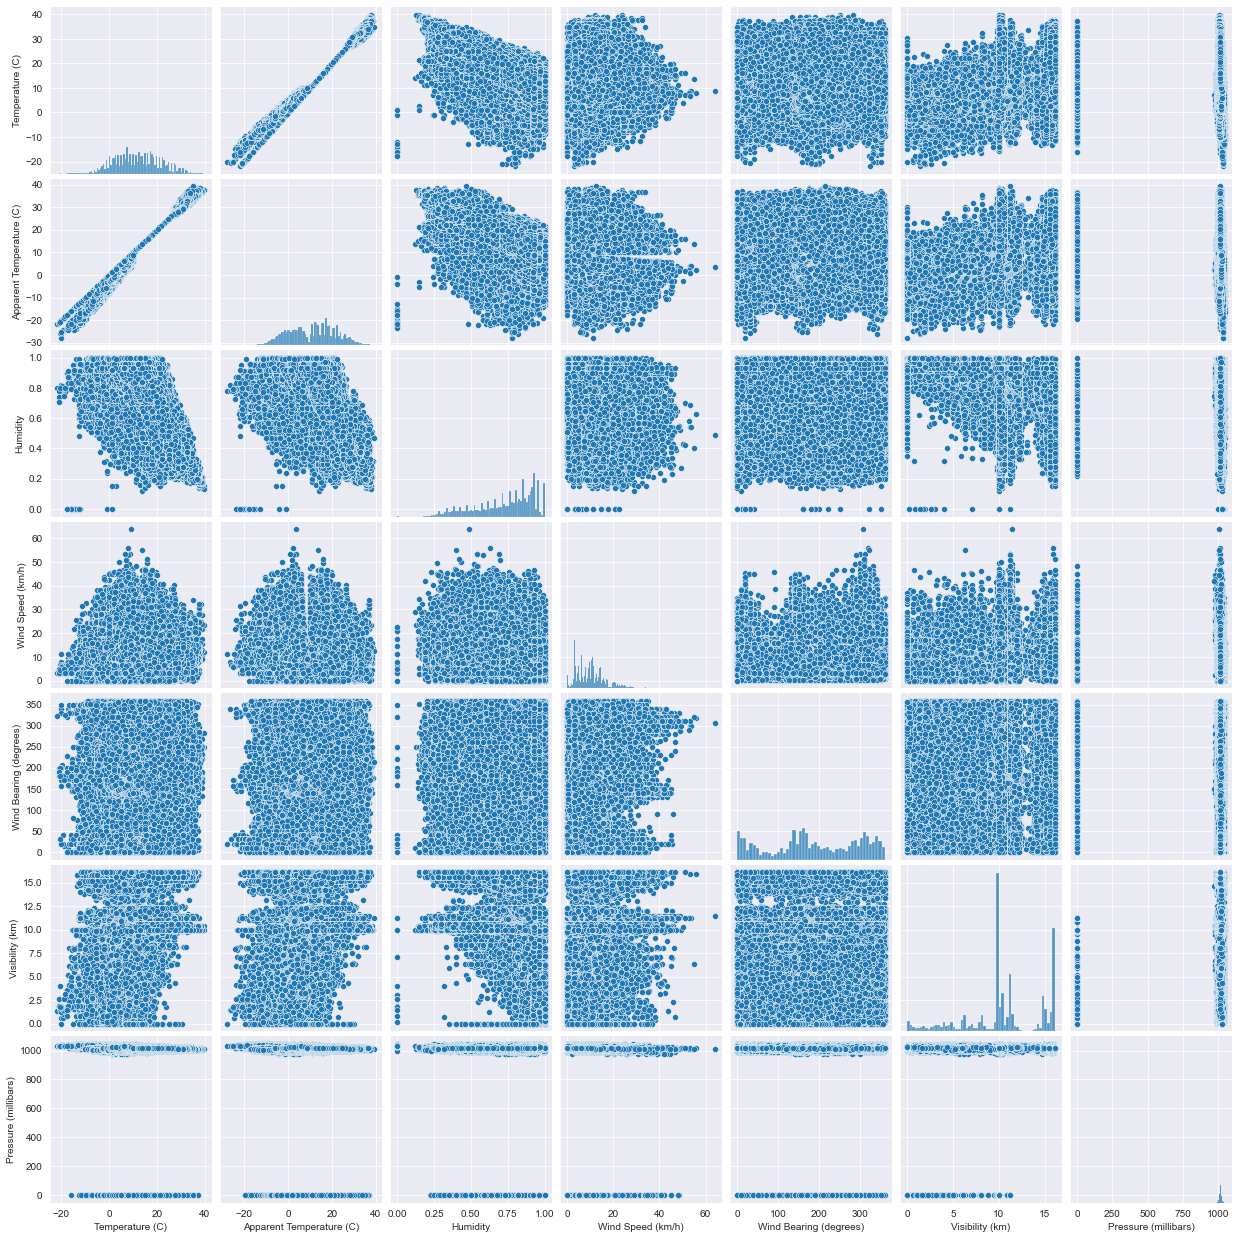

In [17]:
# построить pairplot
sns.pairplot(df);

**Задание 6.** Преобразуйте категориальные переменные при помощи One Hot Encoding (то есть переведите их в дамми-переменные).

In [18]:
df = pd.get_dummies(df, drop_first=True, dummy_na=False)

In [19]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('summary_', '')

**Задание 7.** Выведите корреляционную матрицу переменных. Какие переменные лучше всего коррелируют с целевой (назовите три)? 

**Подсказка:** это пригодится для частей 2 и 3.

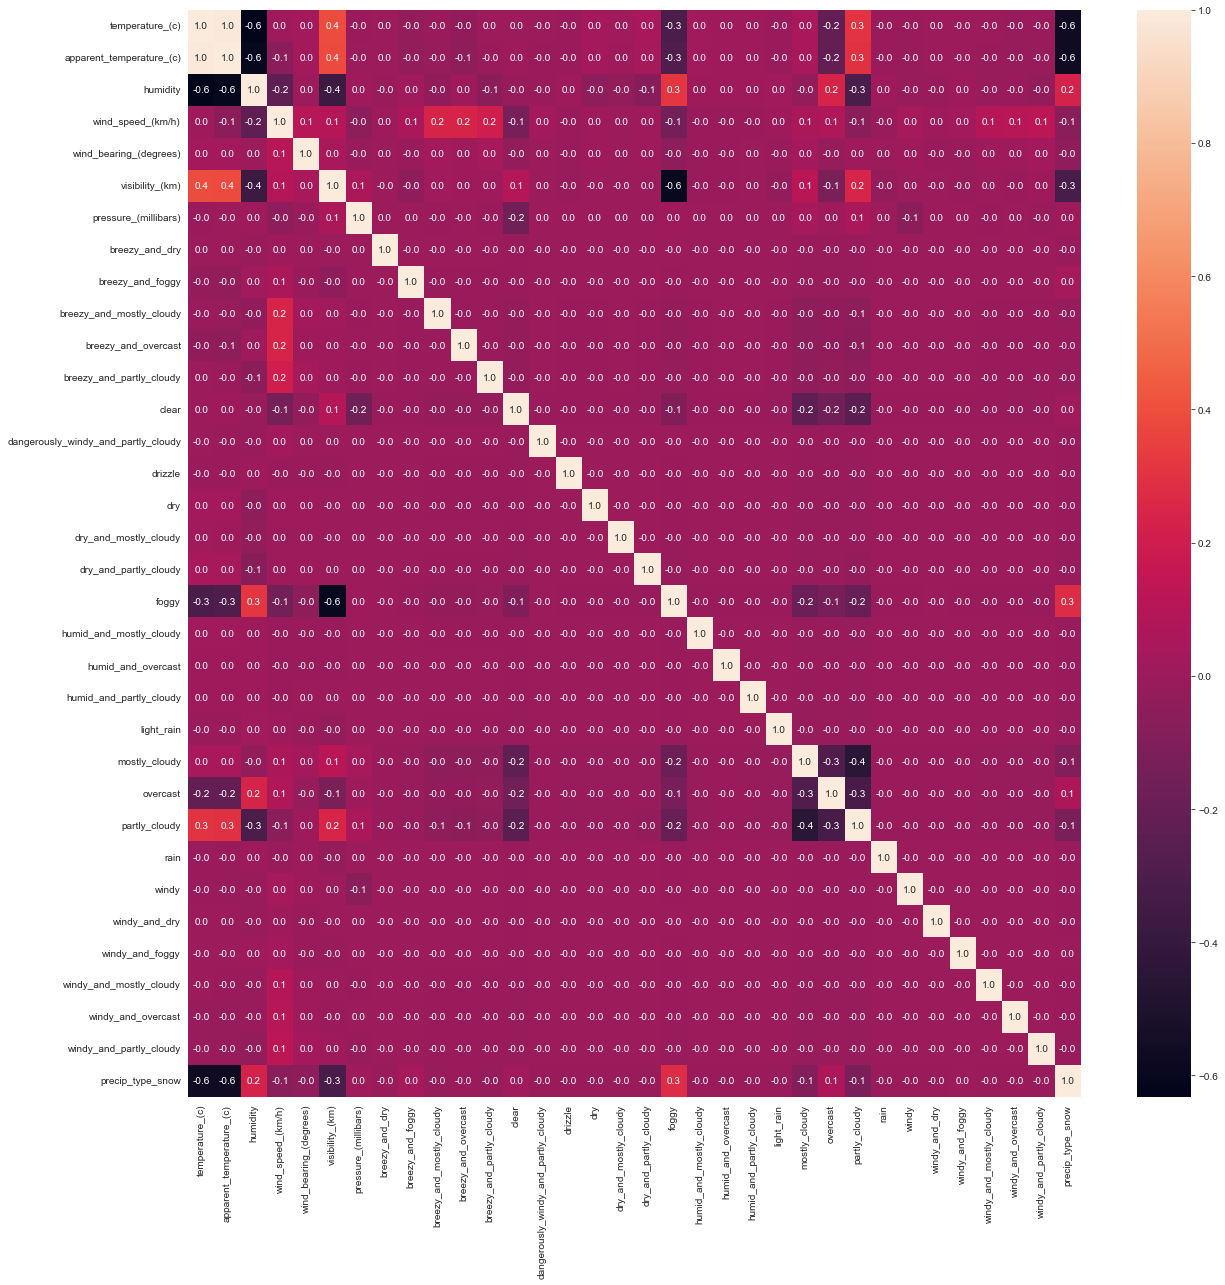

In [20]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot = True, fmt='.1f');

In [21]:
# сделать матрицу корреляции плоской таблицей
corr_matrix = df.corr().stack().reset_index().rename(columns={'level_0': 'criteria_1',
                                                              'level_1': 'criteria_2',
                                                              0: 'value'})

# оставить только признаки связанные с температурой
corr_matrix = corr_matrix[corr_matrix['criteria_1'] == 'temperature_(c)']

# отсортировать признаки по убыванию по силе связи
corr_matrix.sort_values(by='value', ascending=False, inplace=True)

# убрать диагональ матрицы корреляции
corr_matrix.query('value != 1', inplace=True)

# вывести 3 самых коррелирующих с температурой признака
corr_matrix.head(3).loc[:, 'criteria_2':]

,criteria_2,value
1,apparent_temperature_(c),0.992634
5,visibility_(km),0.393813
25,partly_cloudy,0.300294


In [22]:
corr_matrix.loc[:, 'criteria_2':]

,criteria_2,value
1,apparent_temperature_(c),0.992634
5,visibility_(km),0.393813
25,partly_cloudy,0.300294
23,mostly_cloudy,0.046439
17,dry_and_partly_cloudy,0.045918
15,dry,0.033740
4,wind_bearing_(degrees),0.029837
19,humid_and_mostly_cloudy,0.019100
16,dry_and_mostly_cloudy,0.018813
21,humid_and_partly_cloudy,0.013399


**Задание 8.** Разделите данные на регрессоры (`X`) и целевую переменную (`y`). Если всё сделано правильно, то `X` и `y` должны иметь размеры, указанные ниже.

In [23]:
df.head()

,temperature_(c),apparent_temperature_(c),humidity,wind_speed_(km/h),wind_bearing_(degrees),visibility_(km),pressure_(millibars),breezy_and_dry,breezy_and_foggy,breezy_and_mostly_cloudy,...,overcast,partly_cloudy,rain,windy,windy_and_dry,windy_and_foggy,windy_and_mostly_cloudy,windy_and_overcast,windy_and_partly_cloudy,precip_type_snow
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,...,0,0,0,0,0,0,0,0,0,0


X — матрица признаков (на основе каких признаков предсказываем)\
y — целевая переменная (что предсказываем)

In [24]:
X = df.drop(['temperature_(c)'], axis=1).values
y = df['temperature_(c)'].values

In [25]:
print('X:', X.shape)
print('y:', y.shape)

X: (95912, 33)
y: (95912,)


**Задание 8.** Похоже ли распределение целевой переменной на нормальное? Поясните, почему важно, чтобы распределение `y` было похоже на нормальное.

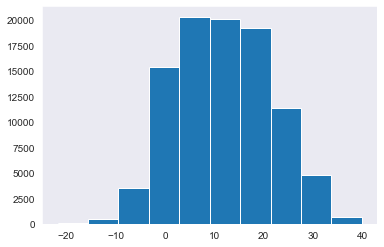

In [26]:
# преобразование в series и вывод гистограммы
pd.Series(y).hist(grid=False);

Распределение имеет форму похожую на форму колокола, но сказать, что это распределение нормально нельзя. Проведём проверку гипотезы о нормальности распределения (тест Шапиро-Уилка).

Сформулируем гипотезу.

H0: Наблюдаемая переменная (температура) распределена нормально — при p-value > 0.05.\
H1: У нас нет оснований полагать, что распределение нормальное — при p-value < 0.05.

Уровень статзначимости (альфа) — 0.05.

In [27]:
# задать уровень статзначимости
alpha = 0.05

# провести тест Шапиро-Уилка на нормальность распределения
results = st.shapiro(y)

# возможные результаты 
test_results = ['отвергаем H0, распределение не нормальное',
                'не удалось отвергнуть H0, распределение нормальное']

if results.pvalue < alpha:
    print(f'Результат теста: {test_results[0]}. P-value: {results.pvalue}')
else:
    print(f'Результат теста: {test_results[1]}. P-value: {results.pvalue}')

Результат теста: отвергаем H0, распределение не нормальное. P-value: 0.0


C:\Users\TheMrGrench\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Часть 2: Построение объясняющей модели (4 балла)

**Задание 9.** На основании предыдущего анализа и логических соображений выберите шесть регрессоров (не считая константный), которые будут включены в объясняющую модель. Помните, что когда мы строим объясняющую модель, выбор переменных должнен быть обоснован (не достаточно использовать предыдущий анализ, выбор каждой переменной должен иметь теоретическое или логическое обоснование). В качестве регрессоров можно брать переменные из `X` или преобразования над ними (`Humidity` и `Humidity`$^2$ будем считать разными регрессорами). 

Создайте ячейку Markdown ниже и запишите в неё функциональный вид модели, которую вы будете оценивать. Поясните выбор регрессоров (не нужно углубляться в физику поведения жидкостей и ссылаться на уравнения Навье-Стокса, достаточно понятной научно-популярной интерпретации) и, если используете, выбор нелинейных преобразований над ними.

$$
y_i = \beta_0 + \beta_1 Humidity  + \beta_2 Visibility (km) + \beta_3 Partly Cloudly + \varepsilon_i
$$

Обоснование выбора переменных:
- $Humidity$ – потому что влажность обратно коррелирует с температурой, чем выше температура, тем ниже влажность и воздух суше.
- $Visibility$ – потому что, так же на матрице показана довольно сильная корреляция с температурой и видимость находится в прямой зависимости, чем лучше видно, тем выше температура и поэтому никакая влажность в воздухе не искажает нам обзор
- $Partly Cloudly$ - этот показатель заключает в себе как и показатели видимости и показатели влажности, и понижение температуры напрямую связано с увеличением облачности, данный показатель взят для баланса, поскольку он более точно показывает нам условия окружающей среды когда температура воздуха не слишком низкая и не слишком высокая

**Задание 10.** Выделите выбранные признаки в переменную `X1`. 

In [28]:
X1 = df.drop(['apparent_temperature_(c)',
               'wind_speed_(km/h)', 'wind_bearing_(degrees)',
               'pressure_(millibars)', 'breezy_and_dry', 'breezy_and_foggy',
               'breezy_and_mostly_cloudy', 'breezy_and_overcast',
               'breezy_and_partly_cloudy', 'clear',
               'dangerously_windy_and_partly_cloudy', 'drizzle', 'dry',
               'dry_and_mostly_cloudy', 'dry_and_partly_cloudy', 'foggy',
               'humid_and_mostly_cloudy', 'humid_and_overcast',
               'humid_and_partly_cloudy', 'light_rain', 'mostly_cloudy', 'overcast',
               'rain', 'windy', 'windy_and_dry', 'windy_and_foggy',
               'windy_and_mostly_cloudy', 'windy_and_overcast',
               'windy_and_partly_cloudy', 'precip_type_snow'], axis=1).values
y1 = df['temperature_(c)'].values

In [29]:
print('X1:', X1.shape)
print('y1:', y1.shape)

X1: (95912, 4)
y1: (95912,)


**Задание 11.** Оцените модель при помощи МНК (минимзации MSE). Прокомментируйте значимость коэффициентов.

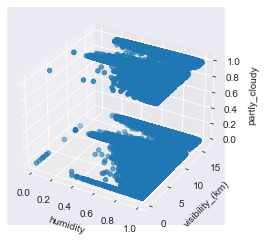

In [30]:
import matplotlib.pyplot as plt


data_crop = df[['humidity', 'visibility_(km)', 'partly_cloudy']]
data_crop.head()
humidity, visibility, partly_cloudy = [column for column in data_crop.values.T]

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=humidity, ys=visibility, zs=partly_cloudy)

ax.set_xlabel('humidity')
ax.set_ylabel('visibility_(km)')
ax.set_zlabel('partly_cloudy')

plt.show()

**Задание 12.** Рассчитайте $R^2$ и MSE на выборке `X1`. Прокомментируйте качество подгонки регрессии.

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import itertools
a = df[['humidity','visibility_(km)','partly_cloudy']]
b = df[['temperature_(c)']]

model_lr_all_features = LinearRegression().fit(a, b)

print('intercept: ', model_lr_all_features.intercept_[0])
for i, j in zip(['humidity','visibility_(km)','partly_cloudy'], model_lr_all_features.coef_[0]):
    print('coef ',i,': ',j)

print('r2_score: ', r2_score(b, model_lr_all_features.predict(a)))
print('MSE: ', mean_squared_error(b, model_lr_all_features.predict(a)))

intercept:  26.686545165000553
coef  humidity :  -26.43427176081821
coef  visibility_(km) :  0.39243989372750376
coef  partly_cloudy :  1.849566151342506
r2_score:  0.4364989805654079
MSE:  51.603547978654646


**Задание 13.** Поясните, как каждый регрессор влияет на зависимую переменную
1. математически ("при увеличении $X$ на 1 $Y$ увеличивается на 3") и 
2. содержательно ("$X$ влияет на $Y$ положительно, потому что...", "$X$ не оказывает влияния на $Y$, потому что...").

$$
y_i = \beta_0 + \beta_1 Humidity  + \beta_2 Visibility (km) + \beta_3 Partly Cloudly + \varepsilon_i
$$

$$
y_i = 26.68 + (-26.43)* Humidity  + 0.39* Visibility (km) + 1.84* Partly Cloudly + \varepsilon_i
$$

### Часть 3: Построение предсказательной модели (4 балла)

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. Код ниже поделит выборку (`X`, `y`) на обучающую (`X_train`, `y_train`), на которой будем *оценивать* модель, и *тестовую* (`X_test`, `y_test`), на которой будем предсказывать. 

In [32]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

1. train — тестовая выборка (обучаемая)
1. test — валидационная выборка (на основе неё проверяем качество модели)

In [33]:
from sklearn.preprocessing import StandardScaler

# стандартизировать и привести все признаки к одному масштабу
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)

In [34]:
from sklearn.linear_model import Ridge

model = Ridge()

# обучить модель на train-выборке
model.fit(X_train_standard, y_train)

y_predict = model.predict(X_test_standard)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'MAE: {mean_absolute_error(y_test, y_predict):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_predict):.2f}')
print(f'R2: {r2_score(y_test, y_predict):.2f}')

MAE: 0.74
MSE: 0.90
R2: 0.99


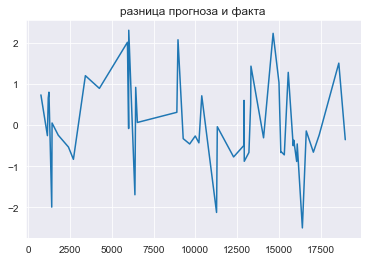

In [36]:
# вывести прогноз в сравнении с фактом
t = (pd.DataFrame({'true_values': y_test,
                   'predict_values': y_predict}).reset_index())

# вывести разницу плана и факта
t['difference'] = t['predict_values'] - t['true_values']

# вывести 50 случайных значений на график
t.sample(50).sort_values(by='index')['difference'].plot(grid=True,
                                                        title='разница прогноза и факта');

In [37]:
pd.DataFrame({'feature': df.drop(columns=['temperature_(c)']).columns.to_list(),
              'value': model.coef_}).sort_values(by='value', ascending=False)#.head(6)['feature'].values

,feature,value
0,apparent_temperature_(c),9.354628
2,wind_speed_(km/h),0.592990
7,breezy_and_foggy,0.025498
32,precip_type_snow,0.020337
16,dry_and_partly_cloudy,0.013575
14,dry,0.012414
15,dry_and_mostly_cloudy,0.005520
20,humid_and_partly_cloudy,0.003057
19,humid_and_overcast,0.001921
18,humid_and_mostly_cloudy,0.001647


**Задание 14.** Сохраните в переменные `X_train_1` и `X_test_1` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9).

Оцените модель на выборке `X_train_1`. Сделайте предсказания на выборках `X_train_1` (то есть обучающей) и `X_test_1` (то есть тестовой). Рассчитайте `MAE` на этих выборках.

In [38]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size = 0.2)

In [39]:
from sklearn.preprocessing import StandardScaler

# стандартизировать и привести все признаки к одному масштабу
scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_standard_1 = scaler.transform(X_train_1)
X_test_standard_1 = scaler.transform(X_test_1)

In [40]:
from sklearn.linear_model import Ridge

model = Ridge()

# обучить модель на train-выборке
model.fit(X_train_standard_1, y_train)

y_predict = model.predict(X_test_standard_1)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'MAE: {mean_absolute_error(y_test_1, y_predict):.2f}')
print(f'MSE: {mean_squared_error(y_test_1, y_predict):.2f}')
print(f'R2: {r2_score(y_test_1, y_predict):.2f}')

MAE: 0.00
MSE: 0.00
R2: 1.00


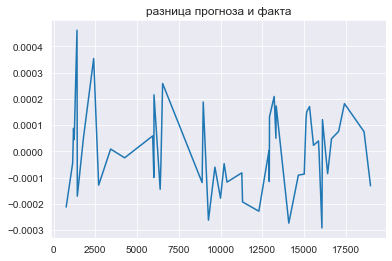

In [42]:
# вывести прогноз в сравнении с фактом
t = (pd.DataFrame({'true_values': y_test_1,
                   'predict_values': y_predict}).reset_index())

# вывести разницу плана и факта
t['difference'] = t['predict_values'] - t['true_values']

# вывести 50 случайных значений на график
t.sample(50).sort_values(by='index')['difference'].plot(grid=True,
                                                        title='разница прогноза и факта');

**Задание 15.** Теперь сохраните в переменные `X_train_2` и `X_test_2` те же признаки из `X_train` и `X_test` соответственно, что и в `X1` (то есть те, которые вы выбрали в задании 9) и ещё какие-то признаки (количество выберите на ваш вкус, главное, чтобы всего признаков было больше, чем в `X1`). Оцените модель на выборке `X_train_2`. Сделайте предсказания на выборках `X_train_2` (то есть обучающей) и `X_test_2` (то есть тестовой). Рассчитайте `MAE` на этих выборках. Удалось ли повысить качество на обучающей выборке? А на тестовой? Поясните.

In [43]:
X2 = df.drop(['apparent_temperature_(c)',
              'wind_speed_(km/h)', 'wind_bearing_(degrees)',
              'pressure_(millibars)', 'breezy_and_dry', 'breezy_and_foggy',
              'breezy_and_mostly_cloudy', 'breezy_and_overcast',
              'breezy_and_partly_cloudy', 'clear',
              'dangerously_windy_and_partly_cloudy', 'drizzle', 'dry',
              'dry_and_mostly_cloudy', 'dry_and_partly_cloudy',
              'humid_and_mostly_cloudy', 'humid_and_overcast',
              'humid_and_partly_cloudy', 'light_rain', 'mostly_cloudy',
              'rain', 'windy', 'windy_and_dry', 'windy_and_foggy',
              'windy_and_mostly_cloudy', 'windy_and_overcast',
              'windy_and_partly_cloudy', 'precip_type_snow'], axis=1).values
y2 = df['temperature_(c)'].values

добавили значение FOGGY и OVERCAST

In [44]:
print('X2:', X2.shape)
print('y2:', y2.shape)

X2: (95912, 6)
y2: (95912,)


In [45]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size = 0.2)

In [46]:
from sklearn.preprocessing import StandardScaler

# стандартизировать и привести все признаки к одному масштабу
scaler = StandardScaler()
scaler.fit(X_train_2)
X_train_standard_2 = scaler.transform(X_train_2)
X_test_standard_2 = scaler.transform(X_test_2)

In [47]:
from sklearn.linear_model import Ridge

model = Ridge()

# обучить модель на train-выборке
model.fit(X_train_standard_2, y_train_2)

y_predict = model.predict(X_test_standard_2)

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f'MAE: {mean_absolute_error(y_test_2, y_predict):.2f}')
print(f'MSE: {mean_squared_error(y_test_2, y_predict):.2f}')
print(f'R2: {r2_score(y_test_2, y_predict):.2f}')

MAE: 0.00
MSE: 0.00
R2: 1.00


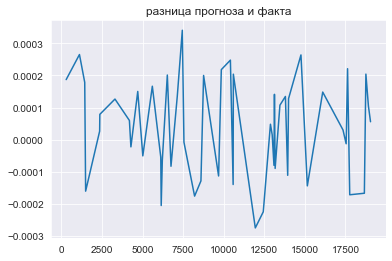

In [52]:
# вывести прогноз в сравнении с фактом
t = (pd.DataFrame({'true_values': y_test_2,
                   'predict_values': y_predict}).reset_index())

# вывести разницу плана и факта
t['difference'] = t['predict_values'] - t['true_values']

# вывести 50 случайных значений на график
t.sample(50).sort_values(by='index')['difference'].plot(grid=True,
                                                        title='разница прогноза и факта');

**Задание 16.** Прокомментируйте значимость коэффициентов модели, оценённой на `X_train_2`.

Значимость коэффициентов модели X_train_2 является существенной, поскольку мы можем делать вывод, что при наличии нескольких ХОРОШО коррелируемых признаков, точность нашего прогноза увеличивается

**Задание 17.** Будем называть модель, оценённую на `X_train_1`, **объясняющей**, а на `X_train_2` – **предсказательной**. На основании заданий 14 и 15 сделайте вывод, подходит ли объясняющая модель для предсказаний. На основании задания 16 сделайте вывод, подходит ли предсказательная модель для объяснительной интерпретации. 

Объясняющая модель X_train_1 показала свою высокую вероятностную предсказательность, сравнивая изначально с моделью X_train - следует сделать вывод, что большое кол-во переменных не дают нам высокого предсказательного потенциала. Метод задействованный в модели X_train_1 называется сниженим размерности, когда убираются лишние зависимые переменные во избежания перекоса за счет своих избыточных коэффицентов. Модель X_train_2 - показала нам, что мы можем улучшить свой прогноз, но совершенно незначительно, в том случае, если добавляемые зависимые переменные практически так же одинаково коррелируют как и в объясняющей модели X_train_1. Первая и вторая модель совершенно спокойно можно считать идентичными.

## Safe Area

Если хотите, напишите здесь что угодно. Можно вставить картинку.